# Домашнее задание: основы DL

## Задание 1

Вспомним 1ое зянятие - мы узнали, что в DL мы можем подбирать оптимальные параметры для любой дифференцируемой модели, считая градиенты по обучаемым параметрам.

В этом задании вам предстоит руками сделать backpropagation для совсем простой модели, чтобы понять, что в torch не происходит никакой магии




Пусть:

$x = [1, 1]^T$

$y = [1, -1]^T$

$z = [-1, 2]^T$


$l = sum(max(0, x*y)) + prod(x + z^2)$

где $sum, prod$ - поэлементные сложения и умножения соответственно



В ответ вам нужно указать $\frac{\partial l}{\partial x}$ и $\frac{\partial l}{\partial z}$, а в ноутбуке отобразить, как вы аналитически получили это значение

Для проверки, что вы правильно поняли идею backpropagation, можете подсчитать значение $\frac{\partial l}{\partial y}$, оно должно проходить assert

Нам нужно посчитать производную по x, это значит что надо сначала взять произвоную по $x_1$, затем по $x_2$, наща функция имеет вид $max(0, x_1 y_1) + max(0, x_2 y_2) + (x_1 + z_1^2)(x_2 + z_2^2)$, знаем, что у нас $x_1 y_1 > 0, x_2 y_2 < 0$, тогда поулчаем f = $ x_1 y_1 + x_1 x_2 + x_1z_2^2 + x_2 z_1^2 + z_2^2 z_1^2$.
 Дальше просто считаем производные частные по нужным нам переменным и получаем, что $\frac{\partial l}{\partial x} = [y_1 + x_2 + z_2^2, x_1 + z_1^2]^T = [6, 2]^T$, аналогично для остальных

In [ ]:
dl_dy = [1, 0]

assert np.all(dl_dy == [1, 0]), "Пока что неверное, попробуйте еще раз и все получится!"

In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Задание 2

На занятиях мы часто говорили про линейные модели, что это просто. Давайте реализуем ее сами и попробуем обучать такую модель для задачи классификации (то есть реализуем логистическую регрессию)

На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта.

Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$.

Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$.

Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

## Задание 2.0

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры ([`nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html)) модели. Иначе говоря здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).



In [2]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(1), requires_grad=True)

    def forward(self, x):
        res =x @ self.weights
        if self.bias:
            res += self.bias_term
        return res


### Датасет

Давайте сгенерируем датасет и посмотрим на него!

In [3]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

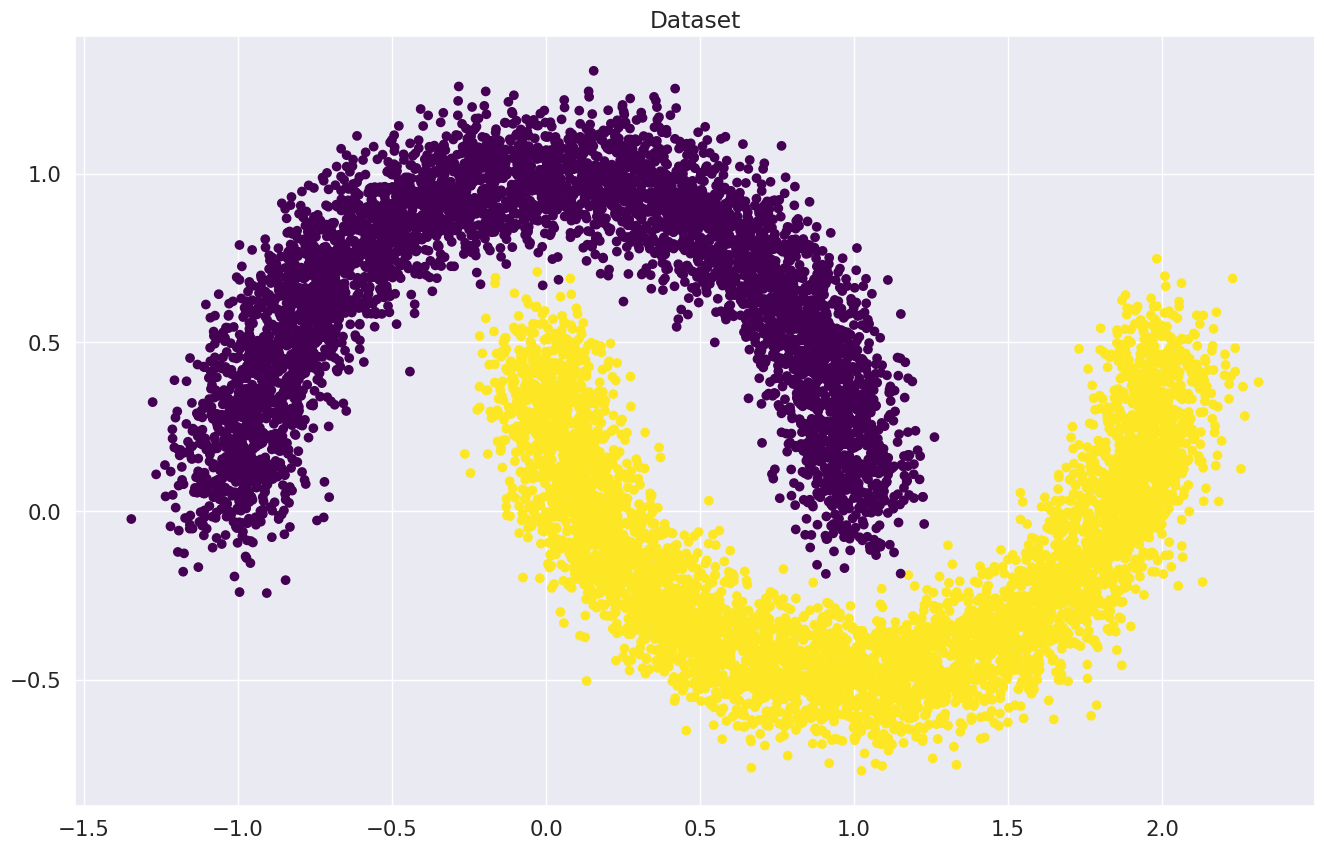

In [4]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [6]:
X_train.shape

(7500, 2)

### Загрузка данных

В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.


In [7]:
X_train_t =  torch.from_numpy(X_train.astype(np.float32))
y_train_t =  torch.from_numpy(y_train.astype(np.float32))
X_val_t =  torch.from_numpy(X_val.astype(np.float32))
y_val_t =  torch.from_numpy(y_val.astype(np.float32))

Создаем `Dataset` и `DataLoader`.

In [11]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [12]:
import catalyst.utils as utils
utils.set_global_seed(42)
linear_regression = LinearRegression(2, 1, True)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

In [8]:
pip install catalyst

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.7/446.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 7.7 MB/s eta 0:00:00


## Задание 2.1 Сколько обучаемых параметров у получившейся модели?

**Ответ:** ... (необходимо внести в форму)

## Задание 2.2

Теперь обучим эту модель

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

In [13]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
prev_bias = torch.zeros_like(linear_regression.bias_term)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch)
        loss = loss_function(outp.view(-1), y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        sigm = nn.Sigmoid()
        probabilities =  sigm(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum()/y_batch.size(0)

        if it % 500000 == 0:
            print(f"Iteration: {it + epoch*len(train_dataset)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        current_bias = linear_regression.bias_term.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol and (prev_bias - current_bias).abs().max() < tol:
            print(f"\nIteration: {it + epoch*len(train_dataset)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
        prev_bias = current_bias
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.5625
Iteration: 7500
Batch accuracy: 0.765625
Iteration: 15000
Batch accuracy: 0.7890625
Iteration: 22500
Batch accuracy: 0.7890625
Iteration: 30000
Batch accuracy: 0.8046875
Iteration: 37500
Batch accuracy: 0.8046875
Iteration: 45000
Batch accuracy: 0.8046875
Iteration: 52500
Batch accuracy: 0.8203125
Iteration: 60000
Batch accuracy: 0.8203125
Iteration: 67500
Batch accuracy: 0.8203125
Iteration: 75000
Batch accuracy: 0.8203125
Iteration: 82500
Batch accuracy: 0.8203125
Iteration: 90000
Batch accuracy: 0.8203125
Iteration: 97500
Batch accuracy: 0.828125
Iteration: 105000
Batch accuracy: 0.828125

Iteration: 105054.Convergence. Stopping iterations.


## Задание 2.2

Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 105054

### Визуализируем результаты

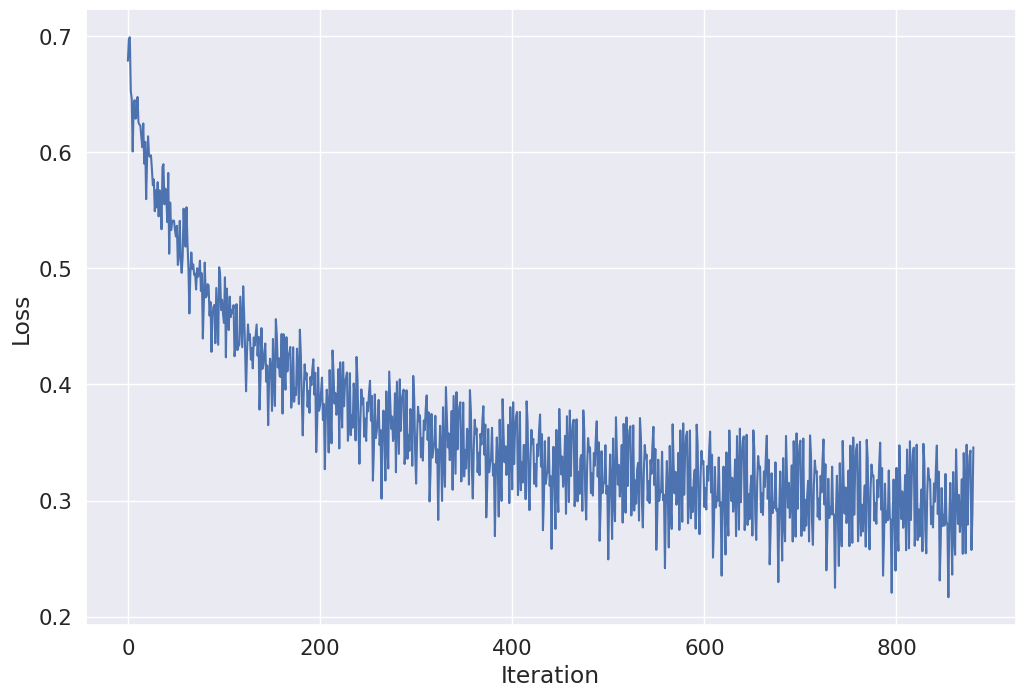

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [14]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probs = torch.sigmoid(outp)
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    predictions = predictions
    return predictions.flatten()

In [15]:
from sklearn.metrics import accuracy_score

out = predict(val_dataloader, linear_regression)
print(accuracy_score(out, y_val_t))

0.8688


## Задание 2.3

Какое `accuracy` получается после обучения?

**Ответ:** 0.8688


# Задание 3

Теперь перейдем к датасету MNIST!

На 2ом и 3ем семинаре мы работали с этим датасетом, поэтому ваша задача взять код от туда и исследовать такой интересный вопрос: какая функция активации лучше всего подходит под эту задачу?


Вам необходимо обучить 4 раза модель ниже и сравнить качество для различных функций активаций (или их отсутствия)

In [16]:
import torchvision
mnist_train = torchvision.datasets.MNIST(
    "./mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor()
)
mnist_val = torchvision.datasets.MNIST(
    "./mnist/", train=False, download=True, transform=torchvision.transforms.ToTensor()
)

# так как это уже унаследованный от Dataset класс, его можно сразу обернуть в даталоадер
train_dataloader = torch.utils.data.DataLoader(
    mnist_train, batch_size=4, shuffle=True,
)

val_dataloader = torch.utils.data.DataLoader(
    mnist_val, batch_size=4, shuffle=False,)

100%|██████████| 9912422/9912422 [00:00<00:00, 100966324.68it/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 36464688.09it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 43527106.66it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14520220.10it/s]


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



In [18]:
from tqdm.notebook import tqdm

activation = nn.LeakyReLU  # нужно перебрать: no_activation, ReLU, LeakyReLU, ELU
per=0

class Lin_my(nn.Module):
    def forward(self, x):
        return x


max_epochs = 10

def testing_act(activation):
    activation = activation
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 128),
        activation(),
        nn.Linear(128, 128),
        activation(),
        nn.Linear(128, 10)
    )
    global per

    crit = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.05)
    load = {"train": train_dataloader, "valid": val_dataloader}

    max_epochs = 10
    res = []
    for epoch in range(max_epochs):
        print(f'progress: {round(per * 100, 2)}%')
        per += 0.025
        for x_batch, y_batch in tqdm(train_dataloader):
            y_new = model(x_batch)
            l = F.cross_entropy(y_new, y_batch)
            l.backward()
            optimizer.step()
            optimizer.zero_grad()

        valid_l = []
        valid_acc = []
        with torch.no_grad():
            for x_valid, y_valid in tqdm(val_dataloader):
                y_new = model(x_valid)
                l = F.cross_entropy(y_new, y_valid)
                valid_l.append(l.numpy())
                valid_acc.extend((torch.argmax(y_new, dim=-1) == y_valid).numpy().tolist())

        res.append(np.mean(valid_acc))

    return res

no_act = testing_act(Lin_my)
leaky = testing_act(nn.LeakyReLU)
rely = testing_act(nn.ReLU)
ely = testing_act(nn.ELU)


progress: 0%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 2.5%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 5.0%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 7.5%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 10.0%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 12.5%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 15.0%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 17.5%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 20.0%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 22.5%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 25.0%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 27.5%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 30.0%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 32.5%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 35.0%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 37.5%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 40.0%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 42.5%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 45.0%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 47.5%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 50.0%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 52.5%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 55.0%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 57.5%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 60.0%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 62.5%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 65.0%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 67.5%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 70.0%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 72.5%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 75.0%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 77.5%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 80.0%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 82.5%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 85.0%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 87.5%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 90.0%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 92.5%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 95.0%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

progress: 97.5%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

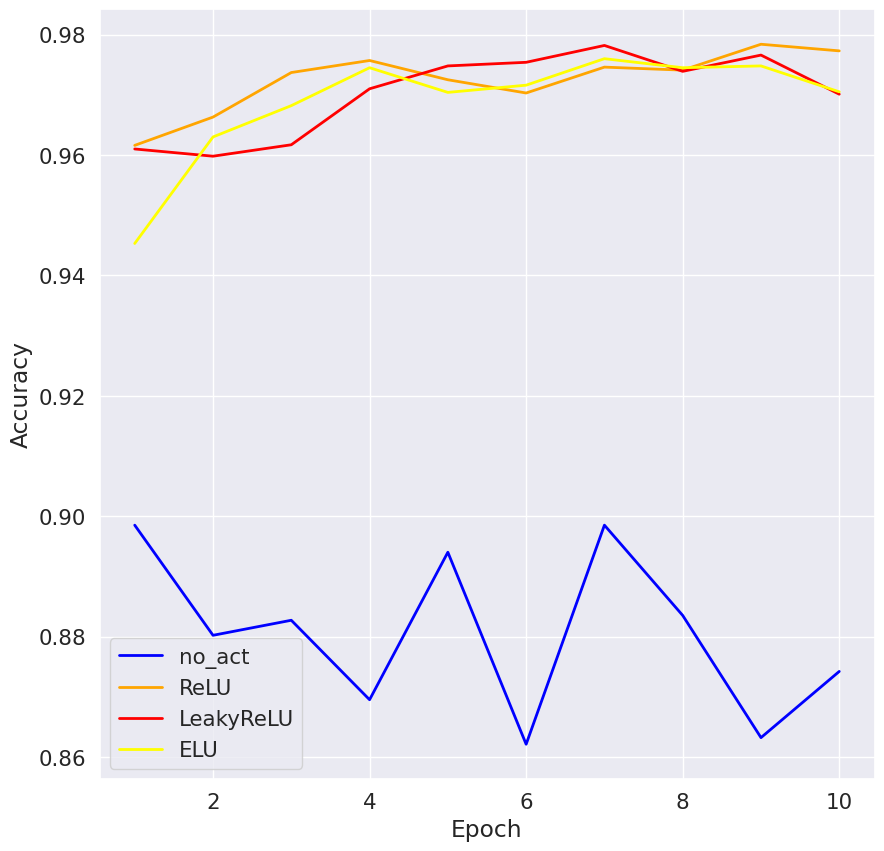

In [19]:

plt.figure(figsize=(10, 10), dpi=100)

epoches = list(range(1,11))

plt.plot(epoches, no_act, color="blue", linewidth=2, label="no_act")
plt.plot(epoches, rely, color="orange", linewidth=2, label="ReLU")
plt.plot(epoches, leaky, color="red", linewidth=2, label="LeakyReLU")
plt.plot(epoches, ely, color="yellow", linewidth=2, label="ELU")


plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


Необходимо построить график: valid accuracy от номера эпохи (максимум 10 эпох) для разных функций активации и выбрать лучшую из них

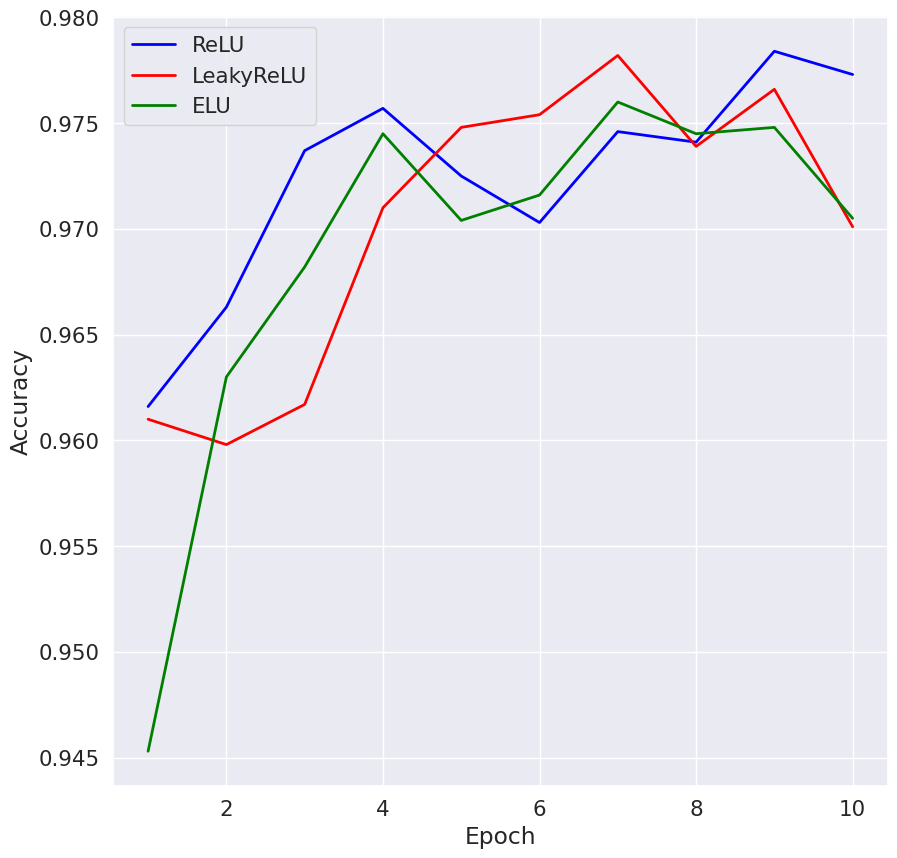

In [20]:
plt.figure(figsize=(10, 10), dpi=100)
plt.plot(epoches, rely, color="blue", linewidth=2, label="ReLU")
plt.plot(epoches, leaky, color="red", linewidth=2, label="LeakyReLU")
plt.plot(epoches, ely, color="green", linewidth=2, label="ELU")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

**Вопрос 3** Какая из активаций показала наивысший `accuracy`?

**Ответ:** необходимо указать в форме



# Задание 4

Теперь обучим архитектуру, которая использует операции nn.Conv2d. На семинарах мы наблюдали, что можем сильно увеличить качество решения.

Давайте посмотрим на архитектуру, предложенную еще в 1998 году - [LeNet](https://en.wikipedia.org/wiki/LeNet)!

In [21]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(5*5*16, 120)  # YOUR CODE HERE
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

Необходимо обучить модель и сравнить дают ли сверточные слои прирост к качеству? Для этого ответить на вопрос

In [ ]:
max_epochs = 10

for epoch in range(max_epochs):
        for x_batch, y_batch in tqdm(train_dataloader):
            y_new = model(x_batch)
            l = F.cross_entropy(y_new, y_batch)
            l.backward()
            optimizer.step()
            optimizer.zero_grad()

        valid_l = []
        valid_acc = []
        with torch.no_grad():
            for x_valid, y_valid in tqdm(val_dataloader):
                y_new = model(x_valid)
                l = F.cross_entropy(y_new, y_valid)
                valid_l.append(l.numpy())
                valid_acc.extend((torch.argmax(y_new, dim=-1) == y_valid).numpy().tolist())

        print(f"Epoch: {epoch + 1}, loss: {np.mean(valid_l)}, accuracy: {np.mean(valid_acc)}"    )

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 1, loss: 0.10091210156679153, accuracy: 0.968


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 2, loss: 0.049966901540756226, accuracy: 0.9843


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 3, loss: 0.056262463331222534, accuracy: 0.9829


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 4, loss: 0.041476618498563766, accuracy: 0.9872


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 5, loss: 0.0738602802157402, accuracy: 0.9798


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 6, loss: 0.04836186394095421, accuracy: 0.9867


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 7, loss: 0.06100819259881973, accuracy: 0.9851


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 8, loss: 0.04629015177488327, accuracy: 0.9897


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 9, loss: 0.052994221448898315, accuracy: 0.9874


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 10, loss: 0.047315601259469986, accuracy: 0.9887


## Задание 4
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** необходимо указать в форме 0.99
